<a href="https://colab.research.google.com/github/diegovrosales/SP1_Laboratorios/blob/master/Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import functools, re, string
from __future__ import absolute_import, division, print_function, unicode_literals

from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Dropout, Conv1D, MaxPooling1D, GRU,SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np
from numpy.random import RandomState
import matplotlib.pylab as plt

import pandas as pd
from sklearn.model_selection import train_test_split

#dark mode
plt.rc_context({'xtick.color':'w', 'ytick.color':'w', 'text.color':'w', 'axes.labelcolor':'w'})

seed=1234
np.random.seed(seed)
tf.random.set_seed(seed)

TensorFlow 2.x selected.


In [0]:
def punctuation_removal(messy_str):
    clean_list = [char for char in messy_str if char not in string.punctuation]
    clean_str = ''.join(clean_list)
    return clean_str

In [3]:
data_url = "https://raw.githubusercontent.com/diegovrosales/SP1_Laboratorios/master/Womens%20Clothing%20E-Commerce%20Reviews2.csv"
ereviews = pd.read_csv(data_url)
text_df = ereviews[['Title', 'ReviewText', 'RecommendedIND']]

text_df['Review'] = text_df['Title'] + ' ' + text_df['ReviewText']
text_df = text_df.drop(labels=['Title','ReviewText'] , axis=1)
text_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,RecommendedIND,Review
0,1,NaN
1,1,NaN
2,0,Some major design flaws I had such high hopes ...
3,1,"My favorite buy! I love, love, love this jumps..."
4,1,Flattering shirt This shirt is very flattering...


In [4]:
text_df.Review.isna().sum()

3811

In [5]:
text_df = text_df[~text_df.Review.isna()]
text_df = text_df.rename(columns={"Recommended IND": "Recommended"})
print("My data's shape is:", text_df.shape)
text_df.head()

My data's shape is: (19675, 2)


,RecommendedIND,Review
2,0,Some major design flaws I had such high hopes ...
3,1,"My favorite buy! I love, love, love this jumps..."
4,1,Flattering shirt This shirt is very flattering...
5,0,Not for the very petite I love tracy reese dre...
6,1,Cagrcoal shimmer fun I aded this in my basket ...


In [0]:
text_df['Review'] = text_df['Review'].apply(lambda x: x.lower())
text_df['Review'] = text_df['Review'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

In [0]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(text_df['Review'].values)
X = tokenizer.texts_to_sequences(text_df['Review'].values)
X = pad_sequences(X)

In [0]:
rng = RandomState()
train = text_df.sample(frac=0.7, random_state=rng)
test = text_df.loc[~text_df.index.isin(train.index)]


In [9]:
embed_dim = 128
lstm_out = 196
max_fatures = 2000

model = Sequential([
    Embedding(max_fatures, embed_dim,input_length = X.shape[1]),
    SpatialDropout1D(0.4),
    LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2),
    Dense(2,activation='softmax')
])

model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 117, 128)          256000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 117, 128)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 196)               254800    
_________________________________________________________________
dense (Dense)                (None, 2)                 394       
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________


In [10]:
Y = pd.get_dummies(text_df['RecommendedIND']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.6, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)
print(test.shape)

(7870, 117) (7870, 2)
(11805, 117) (11805, 2)
(5903, 2)


In [11]:
batch_size = 32
trained = model.fit(X_train, Y_train, epochs = 7, batch_size=batch_size, verbose = 2, validation_data=(X_test, Y_test))

Train on 7870 samples, validate on 11805 samples
Epoch 1/7
7870/7870 - 181s - loss: 0.3867 - accuracy: 0.8426 - val_loss: 0.2784 - val_accuracy: 0.8736
Epoch 2/7
7870/7870 - 177s - loss: 0.2719 - accuracy: 0.8848 - val_loss: 0.3180 - val_accuracy: 0.8802
Epoch 3/7
7870/7870 - 177s - loss: 0.2341 - accuracy: 0.9037 - val_loss: 0.2712 - val_accuracy: 0.8904
Epoch 4/7
7870/7870 - 176s - loss: 0.2023 - accuracy: 0.9187 - val_loss: 0.2708 - val_accuracy: 0.8854
Epoch 5/7
7870/7870 - 176s - loss: 0.1793 - accuracy: 0.9307 - val_loss: 0.2806 - val_accuracy: 0.8875
Epoch 6/7
7870/7870 - 176s - loss: 0.1587 - accuracy: 0.9388 - val_loss: 0.3102 - val_accuracy: 0.8947
Epoch 7/7
7870/7870 - 177s - loss: 0.1404 - accuracy: 0.9460 - val_loss: 0.3285 - val_accuracy: 0.8665


In [12]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
vocab_size = len(tokenizer.word_index) + 1
vocab_size

19159

In [0]:
def plot_accuracy_and_loss(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(10, 10))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.setp(plt.legend().get_texts(), color='black')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1.0])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.setp(plt.legend().get_texts(), color='black')
  plt.ylabel('Cross Entropy')
  plt.ylim([0.0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

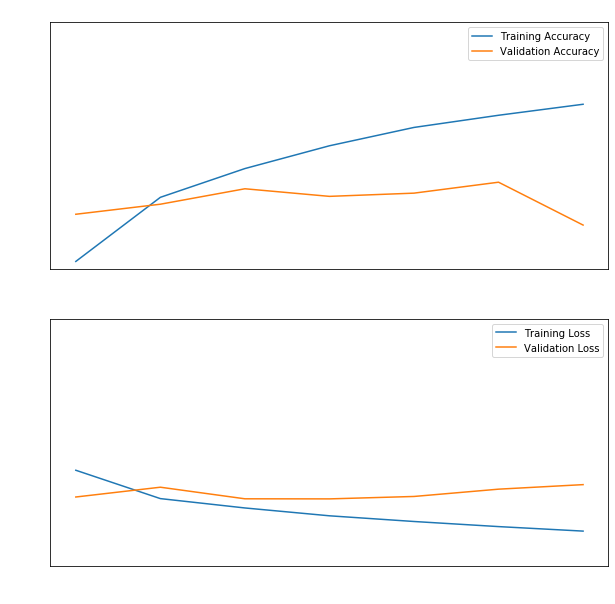

In [14]:
history = trained
plot_accuracy_and_loss(history)